### Elo-merchant-category-recommendation

https://www.kaggle.com/c/elo-merchant-category-recommendation

For each card-id, there are time series data of Merchant Transaction (history and new). 
Reduce the data to customer level and feature engineering are essential. 
This notebook is to construct the features for modeling. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore') 
import random
import matplotlib.pyplot as plt
from datetime import datetime,date
import calendar

from scipy.stats import norm, skew
from scipy.special import boxcox1p

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(len(train),len(test))

201917 123623


In [4]:
df=train.append(test,ignore_index=True) # combine two data frames and join with mechaniant info 
del test
del train
df.head(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325540 entries, 0 to 325539
Data columns (total 6 columns):
card_id               325540 non-null object
feature_1             325540 non-null int64
feature_2             325540 non-null int64
feature_3             325540 non-null int64
first_active_month    325539 non-null object
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 14.9+ MB


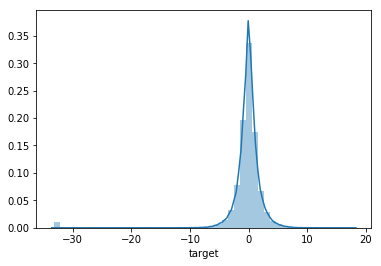

In [40]:
### Target Distribution 
sns.distplot(df[df['target'].notnull()]['target'])

I noticed that there are outliers (maybe not right to call them outliers) in the Target data. It seems that target == 33.12.. is like another category. So I defined a new feature 1) Wired_Value to record those cards. 2)Extract the year, month info from the first_purchase_date column. 

In [6]:
df['Wierd_Value'] = np.where(df['target']<-33,1,0)
df['first_active_month'] = pd.DatetimeIndex(df['first_active_month'])
date = pd.DatetimeIndex(df['first_active_month']) 

df['first_purchase_date_year'] = date.year
df['first_purchase_date_month'] = date.month

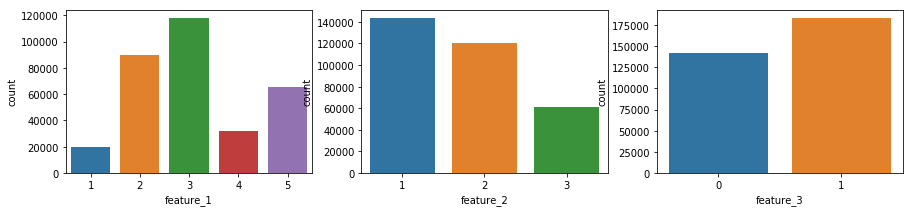

In [7]:
f, ax = plt.subplots(1, 3, figsize=(15, 3)) 
sns.countplot(df['feature_1'],ax=ax[0])
sns.countplot(df['feature_2'],ax=ax[1])
sns.countplot(df['feature_3'],ax=ax[2])

In [8]:
df.to_csv('df.csv',index=False)
#df=pd.read_csv('df.csv')

### historical data and new merchant transaction

In [9]:
ht = pd.read_csv('historical_transactions.csv')
nm = pd.read_csv('new_merchant_transactions.csv')
ht['history'] = 1 # historical data
nm['history'] = 0 # new data  
all_m=ht.append(nm,ignore_index=True) 

In [10]:
del ht
del nm

In [11]:
%whos

Variable   Type             Data/Info
-------------------------------------
all_m      DataFrame                 authorized_flag <...>075392 rows x 15 columns]
ax         ndarray          3: 3 elems, type `object`, 24 bytes
boxcox1p   ufunc            <ufunc 'boxcox1p'>
calendar   module           <module 'calendar' from '<...>b/python3.7/calendar.py'>
date       DatetimeIndex    DatetimeIndex(['2017-06-0<...>length=325540, freq=None)
datetime   type             <class 'datetime.datetime'>
df         DataFrame                        card_id  <...>[325540 rows x 9 columns]
f          Figure           Figure(1080x216)
glob       module           <module 'glob' from '/opt<...>3/lib/python3.7/glob.py'>
norm       norm_gen         <scipy.stats._continuous_<...>object at 0x7f4c4651f8d0>
np         module           <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
pd         module           <module 'pandas' from '/o<...>ages/pandas/__init__.py'>
plt        module           <module 'mat

In [12]:
all_m.head(1)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,history
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,1


### Feature Encoding 
1) fill the missing value  
2) label encoding (category_1, authorized_flag, category_3)  
3) extract year, month, and days information; extract the weekday(weekend) information (0 is Monday and 6 is Sunday); extract information about before(after) midday. 

In [13]:
all_m['category_2'] = all_m['category_2'].fillna(6.0) 
all_m['category_3'] = all_m['category_3'].fillna('D')
all_m['merchant_id'] = all_m['merchant_id'].fillna('None')

mname = all_m['merchant_id'].unique()
classes_code = pd.Categorical(mname).codes
classes = pd.Categorical(mname).categories

code = {x:y for x, y in zip(classes,classes_code)}
all_m['merchant_id'] = all_m['merchant_id'].map(code)


pd.isnull(all_m).sum().sort_values(ascending=False).head(2)

all_m['category_1'] = all_m['category_1'].astype('category').cat.codes
all_m['authorized_flag'] = all_m['authorized_flag'].astype('category').cat.codes
all_m['category_3'] = all_m['category_3'].astype('category').cat.codes

all_m.head(1)

all_m['purchase_date'] = pd.DatetimeIndex(all_m['purchase_date'])
date = pd.DatetimeIndex(all_m['purchase_date']) 

all_m['weekday/end'] = date.dayofweek
all_m['purchase_date_midday'] = np.where(date.hour>12,1,0) # check if the time is after 12pm or before.

all_m.to_csv('all_m.csv',index=False)

In [3]:
all_m = pd.read_csv('all_m.csv')

In [14]:
all_m.head(1)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,history,weekday/end,purchase_date_midday
0,1,C_ID_4e6213e9bc,88,0,0,0,80,151266,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,1,6,1


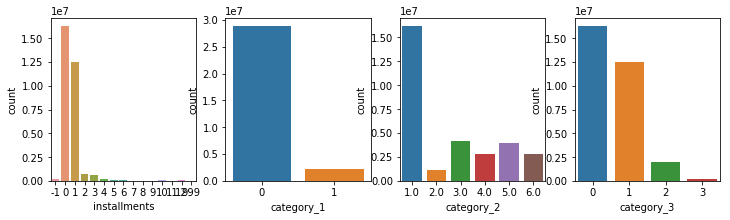

In [3]:
f, ax = plt.subplots(1, 4, figsize=(12, 3)) 
sns.countplot(all_m['installments'],ax=ax[0])
sns.countplot(all_m['category_1'],ax=ax[1])
sns.countplot(all_m['category_2'],ax=ax[2])
sns.countplot(all_m['category_3'],ax=ax[3])

In [15]:
#all_m['purchase_amount_new'] = np.round(all_m['purchase_amount'])
all_m = pd.get_dummies(all_m, columns=['category_2', 'category_3'])

In [16]:
all_m.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount',
       'purchase_date', 'state_id', 'subsector_id', 'history', 'weekday/end',
       'purchase_date_midday', 'category_2_1.0', 'category_2_2.0',
       'category_2_3.0', 'category_2_4.0', 'category_2_5.0', 'category_2_6.0',
       'category_3_0', 'category_3_1', 'category_3_2', 'category_3_3'],
      dtype='object')

In [17]:
all_m['month_lag'].value_counts().head()

-2    3857276
-1    3627430
 0    3470946
-3    3095651
-4    2639805
Name: month_lag, dtype: int64

### Feature Engineer: Applied to all the data 
part1: agg_func   
part2: purchase amount (count) w.r.t the month lag   
part3: purchase frequency 

In [19]:
agg_func = {
    'authorized_flag': ['mean'],
    'category_1':['mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_2_6.0': ['mean'],
    'category_3_0': ['mean'],
    'category_3_1': ['mean'],
    'category_3_2': ['mean'],
    'category_3_3': ['mean'],
    'merchant_id': ['nunique','count'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_date_midday': ['mean'],
    'weekday/end':['mean'],
    'installments':['mean','max','min','std'],
    'purchase_amount':['mean','min','max','std']
    }

In [20]:
hist_merchant = all_m[all_m['history']==1].groupby('card_id').agg(agg_func)
new_merchant = all_m[all_m['history'] ==0].groupby('card_id').agg(agg_func)

In [21]:
hist_merchant.columns = ['hist_'+ '_'.join(col).strip() for col in hist_merchant.columns.values]
hist_merchant.reset_index(inplace=True)

new_merchant.columns = ['new_'+ '_'.join(col).strip() for col in new_merchant.columns.values]
new_merchant.reset_index(inplace=True)

In [23]:
purchase_info = all_m[['card_id','purchase_date','purchase_amount','history','month_lag']]

In [25]:
del all_m #

In [26]:
purchase_info.head(2)

,card_id,purchase_date,purchase_amount,history,month_lag
0,C_ID_4e6213e9bc,2017-06-25 15:33:07,-0.703331,1,-8
1,C_ID_4e6213e9bc,2017-07-15 12:10:45,-0.733128,1,-7


In [27]:
purchase_info['hist_min_date'] = purchase_info[purchase_info['history']==1].\
                                 groupby('card_id').min()['purchase_date'].values[0]

In [28]:
m_lag = purchase_info['month_lag'].unique()

purchase_info = pd.get_dummies(purchase_info, columns=['month_lag'])
purchase_info['diff_days'] = (pd.to_datetime(purchase_info['purchase_date']) - \
                             pd.to_datetime(purchase_info['hist_min_date'])).dt.days

In [29]:
purchase_month = pd.DataFrame(df['card_id'])
purchase_count = pd.DataFrame(df['card_id'])

In [30]:
lag = ['month_lag']
for lag in m_lag:
    a = purchase_info[purchase_info['month_lag_'+str(lag)]==1]\
                                          .groupby(['card_id']).sum()['purchase_amount']
    a=a.reset_index()
    a.columns = ['card_id','month_lag_'+str(lag)]
    purchase_month = purchase_month.merge(a,on='card_id',how='left')
    
    b = purchase_info[purchase_info['month_lag_'+str(lag)]==1]\
                                          .groupby(['card_id']).count()['purchase_amount']
    b=b.reset_index()
    b.columns = ['card_id','Cmonth_lag_'+str(lag)]
    purchase_count = purchase_count.merge(b,on='card_id',how='left')

In [32]:
hist_freq=purchase_info[purchase_info['history'] ==1].sort_values(['diff_days']).\
            groupby('card_id').apply(lambda x: np.mean(np.diff(x['diff_days']))).reset_index()

new_freq=purchase_info[purchase_info['history'] ==0].sort_values(['diff_days']).\
            groupby('card_id').apply(lambda x: np.mean(np.diff(x['diff_days']))).reset_index()

In [36]:
### Combine All the Features 

freq = hist_freq.merge(new_freq,on='card_id',how='left') 
freq.columns=['card_id','hist_freq','new_freq']

part1=purchase_month.merge(freq,on='card_id',how='left')
part2=purchase_count.merge(part1,on='card_id',how='left')
part3=hist_merchant.merge(new_merchant, on='card_id',how='left')

part4=part2.merge(part3,on='card_id',how='left')
final=part4.merge(df,on='card_id',how='left')

In [38]:
final.head(2)

,card_id,Cmonth_lag_-8,Cmonth_lag_-7,Cmonth_lag_-6,Cmonth_lag_-5,Cmonth_lag_-11,Cmonth_lag_0,Cmonth_lag_-3,Cmonth_lag_-9,Cmonth_lag_-4,...,new_purchase_amount_max,new_purchase_amount_std,feature_1,feature_2,feature_3,first_active_month,target,Wierd_Value,first_purchase_date_year,first_purchase_date_month
0,C_ID_92a2005557,3.0,49.0,44.0,20.0,NaN,23.0,21.0,NaN,22.0,...,-0.296112,0.135812,5,2,1,2017-06-01,-0.820283,0,2017.0,6.0
1,C_ID_3d0044924f,15.0,34.0,49.0,14.0,22.0,51.0,26.0,18.0,24.0,...,-0.701858,0.014326,4,1,0,2017-01-01,0.392913,0,2017.0,1.0


In [39]:
final.to_csv('final.csv',index=False)